In [1]:
!pip install timm datasets[vision] keras tensorflow opencv-python-headless matplotlib scikit-learn 

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 764.6 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 730.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 1.4 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 1.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 750.8 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 2.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 2.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.

In [2]:
import timm
import torch
import datasets
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from functools import partial
from sklearn.neighbors import NearestNeighbors
import pandas as pd

import tensorflow as tf
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import (load_img, img_to_array)
from tensorflow.keras.applications.vgg16 import (VGG16, preprocess_input)

2023-11-01 14:34:30.140906: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-01 14:34:30.180303: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-01 14:34:30.180329: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-01 14:34:30.180363: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-01 14:34:30.189508: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: A

 loading a well known model - resnet50 - to understand the package

In [8]:
# loading the pretrained resnet-model and setting the number of classes to 0 to remove the classification layer
model = timm.create_model('vgg16', pretrained=True, num_classes=0)

In [9]:
    # get info about preprocessing applied in the pretrained model
    data_config = timm.data.resolve_model_data_config(model)
    
    # create transformations according to the preprocessing steps
    transforms = timm.data.create_transform(**data_config, is_training=False)


In [13]:
data_config

{'input_size': (3, 224, 224),
 'interpolation': 'bilinear',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 0.875,
 'crop_mode': 'center'}

In [9]:
trans_string = str(transforms)

In [11]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
with open('vgg_transforms.txt', 'w') as f:
    f.write(trans_string)

In [5]:
hejhej = datasets.load_from_disk('../datasets/test_test')

In [6]:
img = hejhej[0]['image']


In [11]:
    import time
    start_time = time.time()
    # apply transformations, convert to tensor and extract features
    features = model(transforms(img).unsqueeze(0)) # unsqueeze adds a dim so the shape is now (1, 3, img_size, img_size)

    # convert from tensor to list
    feature_list = features.tolist()

    # un-nest list
    feature_list_unnest = feature_list[0]

    end_time = time.time() - start_time

In [12]:
end_time

2.4533822536468506

In [10]:
resnet.default_cfg['input_size'][1]

224

In [56]:
# creating a random tensor
x = torch.randn(1,3,224,224)

In [57]:
# extract features using resnet
o = resnet(x)

In [58]:
# checking the shape
o.shape

torch.Size([1, 2048])

Makes sense, as the final **pooled** layer of ResNet50 is of size 2048. This is the embedded feature vector

## The best performing model - EVA-CLIP

In [3]:
# load model without the classification layers
model = timm.create_model('eva_giant_patch14_336.clip_ft_in1k', pretrained=True, num_classes=0)
model = model.eval()

model.safetensors:   0%|          | 0.00/4.05G [00:00<?, ?B/s]

KeyboardInterrupt: 

In [4]:
model

Eva(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-39): 40 x EvaBlock(
      (norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
      (attn): EvaAttention(
        (qkv): Linear(in_features=1408, out_features=4224, bias=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=1408, out_features=1408, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path1): Identity()
      (norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1408, out_features=6144, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=6144, out_features=1408, bias=True)
        (drop2): Dropout(p=

In [4]:
model.default_cfg['input_size']

(3, 336, 336)

In [ ]:
ds_test = datasets.load_from_disk('../datasets/wiki_test')

In [13]:
features = []

for i in range(10):
    img = ds_test[i]['image']
    img = img.resize((336, 336))
    img_array = img_to_array(img)

    # expand to fit dimensions
    expanded_img_array = np.expand_dims(img_array, axis=0)
    array_transposed = np.transpose(expanded_img_array, (0, 3, 1, 2))
    preprocessed_img = (array_transposed/255.0)
    inp = torch.from_numpy(preprocessed_img)
    feature = model(inp)
    feature_list = feature.tolist()
    feature_list = feature_list[0]

    features.append(feature_list)

In [10]:
def feature_extraction(img, img_size, chosen_model):
    
    # resize image to fit with model
    img = img.resize((img_size, img_size))
    # convert to np.array
    img_array = img_to_array(img)
    # expand dimensions (n_samples, 3, img_size, img_size)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    # transpose array to fit PyTorch's format
    array_transposed = np.transpose(expanded_img_array, (0, 3, 1, 2))
    # standardize
    preprocessed_img = (array_transposed/255.0)
    # convert to torch
    inp = torch.from_numpy(preprocessed_img)
    # extract features from model
    feature = chosen_model(inp)
    # convert from torch to list
    feature_list = feature.tolist()
    # un-nest list
    feature_list = feature_list[0]

    return feature_list

In [6]:
ds_train = datasets.load_from_disk('../datasets/wiki_train')

In [7]:
subset = ds_train.select(list(range(1000)))

In [15]:
embeddings = []

for i in range(len(subset)):
    image = subset[i]['image']
    feature = feature_extraction(image, 336, model)
    embeddings.append(feature)

In [19]:
# find K-nearest neighbors
def find_neighbors(feature_list, target_image):
    '''
    Calculate nearest neighbors to a target image using a feature list
    Saves a .csv file from a Pandas dataframe containing the 5 closest images

    Arguments:
    - feature_list: list of extracted features for each image
    - filenames: list of filenames for data directory
    - target_image: name of target image
    - out_folder: where to save the output csv

    Returns:
    - A Pandas series containing the names of the 5 nearest neighbors.
    '''

    # initialize K-nearest neighbors algorithm
    neighbors = NearestNeighbors(n_neighbors=10, 
                            algorithm='brute',
                            metric='cosine').fit(feature_list)

    # find the index of target image in filenames list
    

    # save the indices and distances of the neighbors to the target image
    distances, indices = neighbors.kneighbors([feature_list[target_image]])

    # initialize empty lists
    idxs = []
    dist = []
    
        # save the 5 closest images' indices and distances
    for i in range(1,6):
        idxs.append(indices[0][i])
        dist.append(distances[0][i])
    
    # save the filenames of the 5 closest images
    #names = [filenames[i] for i in idxs]

    # create dataframe
    data = pd.DataFrame({
                        "distance_score" : pd.Series(dist),
                        'index': pd.Series(idxs)})
    
    # save as csv
    #data.to_csv(os.path.join("out", out_folder, f"{target_image}.csv"))
    
    # return filenames as a pandas series to be used in the plotting function
    return data

def show_plot(names, target_image, dataset):
    '''
    Plot target image next to the five closest images

    Arguments:
    - path: path to folder where image data is stored
    - names: the filenames of the 5 closest images. Must be a pandas series
    - target_image: target input image
    - folder: specifies in what folder in output to save the plot to
    
    Returns:
    None
    '''
    
    # arrange plots
    f, axarr = plt.subplots(2, 3)
    
    # print target image
    axarr[0,0].imshow(dataset[target_image]['image'])
    axarr[0,0].title.set_text('Target Image')

    # plot 5 most similar next to it
    axarr[0,1].imshow(dataset[names[0]]['image'])
    axarr[0,2].imshow(dataset[names[1]]['image'])
    axarr[1,0].imshow(dataset[names[2]]['image'])
    axarr[1,1].imshow(dataset[names[3]]['image'])
    axarr[1,2].imshow(dataset[names[4]]['image'])
    
    # remove axes from plot
    for ax in f.axes:
        ax.axison = False

    plt.show()

In [21]:
def plot_neighbors(feature_list, target_image, dataset):

    # find closest images and save in a df
    data = find_neighbors(feature_list, target_image)

    # save the indices of the closest images
    indices = data['index'].tolist()

    # plot them
    show_plot(indices, target_image, dataset)

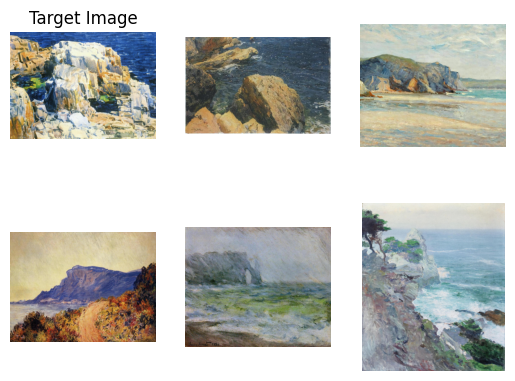

In [25]:
plot_neighbors(embeddings, 800, subset)

In [28]:
from functools import partial

wikiart = datasets.load_dataset("huggan/wikiart", split='train', streaming=True)

def gen_from_iterable_dataset(iterable_ds):
    yield from iterable_ds

ds = datasets.Dataset.from_generator(partial(gen_from_iterable_dataset, wikiart), features=wikiart.features)

#ds.save_to_disk("wikiart_50k")

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

KeyboardInterrupt: 

In [9]:
subset.features

{'image': Image(decode=True, id=None),
 'artist': ClassLabel(names=['Unknown Artist', 'boris-kustodiev', 'camille-pissarro', 'childe-hassam', 'claude-monet', 'edgar-degas', 'eugene-boudin', 'gustave-dore', 'ilya-repin', 'ivan-aivazovsky', 'ivan-shishkin', 'john-singer-sargent', 'marc-chagall', 'martiros-saryan', 'nicholas-roerich', 'pablo-picasso', 'paul-cezanne', 'pierre-auguste-renoir', 'pyotr-konchalovsky', 'raphael-kirchner', 'rembrandt', 'salvador-dali', 'vincent-van-gogh', 'hieronymus-bosch', 'leonardo-da-vinci', 'albrecht-durer', 'edouard-cortes', 'sam-francis', 'juan-gris', 'lucas-cranach-the-elder', 'paul-gauguin', 'konstantin-makovsky', 'egon-schiele', 'thomas-eakins', 'gustave-moreau', 'francisco-goya', 'edvard-munch', 'henri-matisse', 'fra-angelico', 'maxime-maufra', 'jan-matejko', 'mstislav-dobuzhinsky', 'alfred-sisley', 'mary-cassatt', 'gustave-loiseau', 'fernando-botero', 'zinaida-serebriakova', 'georges-seurat', 'isaac-levitan', 'joaquã\xadn-sorolla', 'jacek-malczewski'

In [8]:
subset_subset = subset.select(list(range(10)))

In [11]:
embeddings = []

for i in range(len(subset_subset)):
    image = subset_subset[i]['image']
    feature = feature_extraction(image, 224, model)
    embeddings.append(feature)


In [15]:
subset_subset_new = subset_subset.add_column("embedding", embeddings)

In [16]:
len(subset_subset_new[0]['embedding'])

4096

In [12]:
def testy_fun(dataset, embeddings, colname, new_dataset_name):

    testyfun_data = dataset.add_column(colname, embeddings)

    testyfun_data.save_to_disk(new_dataset_name)

In [13]:
testy_fun(subset_subset, embeddings, 'EVA-CLIP-embedding', '../datasets/test_data')

Saving the dataset (0/1 shards):   0%|          | 0/10 [00:00<?, ? examples/s]

In [14]:
hejhej = datasets.load_from_disk('../datasets/test_data/')

In [18]:
pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [19]:
from tqdm.notebook import tqdm, trange

In [23]:
import tqdm

In [34]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    n_stacks = len(dims) - 1
    # input
    input_img = tf.keras.layers.Input(shape=(dims[0],), name='input') # shape er en 1D vector som er længden af output af densenet
    x = input_img
    # internal layers of the encoder
    for i in range(n_stacks-1): # specificerer antallet af lag baseret på n_stacks variablen
        # så her, 3 lag
        # tror koden laver de tre lag (går dybere). det sidste (x) betyder, at det forrige x tages som input
        x = tf.keras.layers.Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # bottleneck
    # koden tager den sidste værdi i dims-vectoren (10) som længden på vektoren --> tager x som input
    encoded = tf.keras.layers.Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded # definerer ny input variabel
    # hidden layers of the decoder
    for i in range(n_stacks-1, 0, -1):
        x = tf.keras.layers.Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = tf.keras.layers.Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return tf.keras.models.Model(inputs=input_img, outputs=decoded, name='AE'), tf.keras.models.Model(inputs=input_img, outputs=encoded, name='encoder')

dims = [1024, 500, 500, 2000, 10] # forstår ikke hvad formålet med den her er 

hej lol:   0%|          | 0/10 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [14]:
ds = datasets.load_from_disk("../datasets/new_testy_train")

In [24]:
def feature_extraction(img, img_size, chosen_model):
    
    # resize image to fit with model
    img = img.resize((img_size, img_size))
    # convert to np.array
    img_array = img_to_array(img)
    # expand dimensions (n_samples, 3, img_size, img_size)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    # transpose array to fit PyTorch's format
    array_transposed = np.transpose(expanded_img_array, (0, 3, 1, 2))
    # normalize
    preprocessed_img = (array_transposed/255.0)
    # convert to torch
    inp = torch.from_numpy(preprocessed_img)
    # extract features from model
    feature = chosen_model(inp)
    # convert from torch to list
    feature_list = feature.tolist()
    # un-nest list
    feature_list = feature_list[0]

    return feature_list

In [23]:
ds[7]['resnet_features']

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.42425721883773804,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,


In [8]:
image = ds[0]['image']

NameError: name 'ds' is not defined

In [54]:
model = timm.create_model('vgg16', pretrained=True, num_classes=0)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
hejhej = datasets.load_from_disk("../datasets/resnet_testy_train")

In [55]:
# get model specific transformations
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

In [56]:
data_config # finds the input size, means and standard deviation to use for standardization

{'input_size': (3, 224, 224),
 'interpolation': 'bilinear',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 0.875,
 'crop_mode': 'center'}

In [57]:
transforms

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [24]:
test = transforms(img)

torch.Tensor

In [34]:
img = hejhej[0]['image']

In [37]:
output = model(transforms(img).unsqueeze(0))

In [40]:
test = (transforms(img).unsqueeze(0))

In [41]:
test.shape

torch.Size([1, 3, 224, 224])

In [22]:
print(output)

tensor([[1.1614, 0.0238, 0.0000,  ..., 0.0000, 0.0202, 0.0000]],
       grad_fn=<ViewBackward0>)


In [23]:
output.shape

torch.Size([1, 2048])

In [48]:
ds = datasets.load_from_disk("../datasets/test_train_new")

In [49]:
ds.features

{'image': Image(decode=True, id=None),
 'artist': ClassLabel(names=['Unknown Artist', 'boris-kustodiev', 'camille-pissarro', 'childe-hassam', 'claude-monet', 'edgar-degas', 'eugene-boudin', 'gustave-dore', 'ilya-repin', 'ivan-aivazovsky', 'ivan-shishkin', 'john-singer-sargent', 'marc-chagall', 'martiros-saryan', 'nicholas-roerich', 'pablo-picasso', 'paul-cezanne', 'pierre-auguste-renoir', 'pyotr-konchalovsky', 'raphael-kirchner', 'rembrandt', 'salvador-dali', 'vincent-van-gogh', 'hieronymus-bosch', 'leonardo-da-vinci', 'albrecht-durer', 'edouard-cortes', 'sam-francis', 'juan-gris', 'lucas-cranach-the-elder', 'paul-gauguin', 'konstantin-makovsky', 'egon-schiele', 'thomas-eakins', 'gustave-moreau', 'francisco-goya', 'edvard-munch', 'henri-matisse', 'fra-angelico', 'maxime-maufra', 'jan-matejko', 'mstislav-dobuzhinsky', 'alfred-sisley', 'mary-cassatt', 'gustave-loiseau', 'fernando-botero', 'zinaida-serebriakova', 'georges-seurat', 'isaac-levitan', 'joaquã\xadn-sorolla', 'jacek-malczewski'

In [50]:
ds[0]['eva_clip']

[1.0701295137405396,
 0.04462500289082527,
 1.2622510194778442,
 -2.110938787460327,
 1.5531116724014282,
 -1.108444333076477,
 -1.5043869018554688,
 0.39399048686027527,
 0.4189736247062683,
 1.3610444068908691,
 1.418596863746643,
 -0.08249422162771225,
 -0.0800682082772255,
 -1.4669491052627563,
 0.17218399047851562,
 -0.8854407668113708,
 0.09255693852901459,
 1.739201307296753,
 -1.0927525758743286,
 -0.1677393615245819,
 1.3451498746871948,
 0.011633921414613724,
 -0.5458158254623413,
 1.7947566509246826,
 -0.6331512928009033,
 -0.7882343530654907,
 0.39749234914779663,
 -0.3465164601802826,
 1.076423168182373,
 0.5586296916007996,
 1.4185806512832642,
 3.4344851970672607,
 1.153451919555664,
 -0.3435649871826172,
 2.4556078910827637,
 -1.5198901891708374,
 0.07054555416107178,
 0.6101087331771851,
 0.9658030867576599,
 0.16985288262367249,
 1.4809918403625488,
 0.3660988211631775,
 -0.48299580812454224,
 0.023904774338006973,
 0.18003636598587036,
 1.492178201675415,
 1.45960021

In [1]:
!pip install timm
import timm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 926.9 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 29.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 37.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 18.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 53.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 13.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 25.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 24.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 20.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━

In [5]:
timm.list_models(pretrained = True)

['bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patch16_224.in1k_ft_in1k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k',
 'botnet26t_256.c1_in1k',
 'caformer_b36.sail_in1k',
 'caformer_b36.sail_in1k_384',
 'caformer_b36.sail_in22k',
 'caformer_b36.sail_in22k_ft_in1k',
 'caformer_b36.sail_in22k_ft_in1k_384',
 'caformer_m36.sail_in1k',
 'caformer_m36.sail_in1k_384',
 'caformer_m36.sail_in22k',
 'caformer_m36.sail_in22k_ft_in1k',
 'caformer_m36.sail_in22k_ft_in1k_384',
 'caformer_s18.sail_in1k',
 'caformer_s18.s

In [3]:
model = timm.create_model('eva02_large_patch14_448.mim_m38m_ft_in22k_in1k', pretrained=True, num_classes=0)
model.eval(

/home/ucloud/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Eva(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (rope): RotaryEmbeddingCat()
  (blocks): ModuleList(
    (0-23): 24 x EvaBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): EvaAttention(
        (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLU(
        (fc1_g): Linear(in_features=1024, out_features=2730, bias=True)
        (fc1_x): Linear(in

In [14]:
hejhej

Dataset({
    features: ['image', 'artist', 'genre', 'style'],
    num_rows: 2
})

In [25]:
def compress_data(ds_train, feature_col, compressed_size):

    inp_shape = len(ds_train[0][feature_col])

    inp = Input(shape=(inp_shape,))

    compressed = Dense(compressed_size, activation = 'relu')(inp) # problem at bruge relu her ??? 

    out = Dense(inp_shape, activation = 'relu')(compressed)

    model = Model(inputs=inp, outputs = out)

    return model

In [3]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

In [11]:
testy_test = datasets.load_from_disk('../datasets/test_test_new')
testy_train = datasets.load_from_disk('../datasets/test_train_new')

In [18]:
testy

Dataset({
    features: ['image', 'artist', 'genre', 'style', 'eva_clip'],
    num_rows: 2
})

In [26]:
comp_model = compress_data(ds_train=testy_test, feature_col = 'eva_clip', compressed_size=800)

In [27]:
comp_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1408)]            0         
                                                                 
 dense_1 (Dense)             (None, 800)               1127200   
                                                                 
 dense_2 (Dense)             (None, 1408)              1127808   
                                                                 
Total params: 2255008 (8.60 MB)
Trainable params: 2255008 (8.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
comp_model.compile(optimizer='adam', loss='mse')

In [29]:
comp_model.fit(testy_train['eva_clip'], testy_train['eva_clip'], epochs=5)

Epoch 1/5
1/1 [==============================] - 0s 335ms/step - loss: 1.4359
Epoch 2/5
1/1 [==============================] - 0s 68ms/step - loss: 1.0966
Epoch 3/5
1/1 [==============================] - 0s 67ms/step - loss: 1.0049
Epoch 4/5
1/1 [==============================] - 0s 71ms/step - loss: 0.9416
Epoch 5/5
1/1 [==============================] - 0s 102ms/step - loss: 0.8978


In [31]:
encoder = Model(comp_model.input, comp_model.layers[-2].output)
encoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1408)]            0         
                                                                 
 dense_1 (Dense)             (None, 800)               1127200   
                                                                 
Total params: 1127200 (4.30 MB)
Trainable params: 1127200 (4.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
predictions = encoder.predict(testy_train['eva_clip'])

1/1 [==============================] - 0s 47ms/step


In [38]:
len(set(testy_train['genre']))

5

In [22]:
testtt = comp_model.predict(testy_train['eva_clip'])

1/1 [==============================] - 0s 127ms/step


In [24]:
testtt.shape

(8, 800)

In [20]:
comp_model.compile(optimizer='adamax', loss='MeanAbsoluteError')

In [21]:
comp_model.fit(testy_train['eva_clip'], epochs=5)

Epoch 1/5


ValueError: in user code:

    File "/home/ucloud/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/home/ucloud/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ucloud/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/home/ucloud/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1128, in train_step
        self._validate_target_and_loss(y, loss)
    File "/home/ucloud/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1082, in _validate_target_and_loss
        raise ValueError(

    ValueError: Target data is missing. Your model was compiled with loss=MeanAbsoluteError, and therefore expects target data to be provided in `fit()`.
